In [23]:
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 

In [15]:
# define a function to convert a vector of time series into a 2D matrix
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix = []
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix

In [16]:

# random seed
np.random.seed(1234)

# load the data
path_to_dataset = 'convertcsv.csv'
sequence_length = 20

# vector to store the time series
vector_vix = []
with open(path_to_dataset) as f:
    next(f) # skip the header row
    for line in f:
        fields = line.split(',')
        vector_vix.append(float(fields[52]))

# convert the vector to a 2D matrix
matrix_vix = convertSeriesToMatrix(vector_vix, sequence_length)

# shift all data by mean
matrix_vix = np.array(matrix_vix)
shifted_value = matrix_vix.mean()
matrix_vix -= shifted_value
print ("Data  shape: ", matrix_vix.shape)
print(matrix_vix.shape[0])
# split dataset: 90% for training and 10% for testing
train_row = int(round(0.9 * matrix_vix.shape[0]))
train_set = matrix_vix[:train_row, :]

# shuffle the training set (but do not shuffle the test set)
np.random.shuffle(train_set)
# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1]
# the test set
X_test = matrix_vix[train_row:, :-1]
y_test = matrix_vix[train_row:, -1]

# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# build the model
model = Sequential()
# layer 1: LSTM
model.add(LSTM(units=100, input_shape=(19, 1), return_sequences=True))
model.add(Dropout(0.2))
# layer 2: LSTM
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(units=1))
model.add(Activation('linear'))
# compile the model
model.compile(loss="mse", optimizer="rmsprop")
print(model.summary())


# train the model
model.fit(X_train, y_train, batch_size=512, epochs=50, validation_split=0.05, verbose=1)


# evaluate the result
test_mse = model.evaluate(X_test, y_test, verbose=1)
print ('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(y_test)))

# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))



Data  shape:  (1920, 20)
1920
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 19, 100)           40800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 19, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
__________________

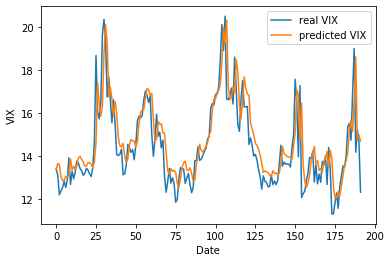

[[ 9.57390086e-04 -2.89042610e-01 -1.19904261e+00 ...  1.83095739e+00
   1.29095739e+00 -1.07904261e+00]
 [-2.57449964e-01 -5.47449964e-01 -1.45744996e+00 ...  1.57255004e+00
   1.03255004e+00 -1.33744996e+00]
 [-2.03657964e-01 -4.93657964e-01 -1.40365796e+00 ...  1.62634204e+00
   1.08634204e+00 -1.28365796e+00]
 ...
 [-1.37321744e+00 -1.66321744e+00 -2.57321744e+00 ...  4.56782557e-01
  -8.32174432e-02 -2.45321744e+00]
 [-1.58039317e+00 -1.87039317e+00 -2.78039317e+00 ...  2.49606825e-01
  -2.90393175e-01 -2.66039317e+00]
 [-1.30212937e+00 -1.59212937e+00 -2.50212937e+00 ...  5.27870632e-01
  -1.21293676e-02 -2.38212937e+00]]


In [17]:
diviation = y_test - predicted_values


# plot the results
fig = plt.figure()
plt.plot(y_test + shifted_value, label='real VIX')
plt.plot(predicted_values + shifted_value, label='predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()
fig.savefig('output_prediction.jpg', bbox_inches='tight')

print(diviation)
# save the result into txt file
test_result = list(zip(predicted_values, y_test)) + shifted_value
np.savetxt('output_result.txt', test_result)

In [18]:
result = diviation.flatten()
print(result)

[ 9.57390086e-04 -2.89042610e-01 -1.19904261e+00 ...  5.27870632e-01
 -1.21293676e-02 -2.38212937e+00]


In [19]:
print(predicted_values + shifted_value)

[[-3.1151204 ]
 [-2.856713  ]
 [-2.910505  ]
 [-3.4762926 ]
 [-3.6542473 ]
 [-3.6471782 ]
 [-3.454882  ]
 [-3.5255713 ]
 [-3.3462038 ]
 [-2.6496255 ]
 [-3.1568527 ]
 [-2.9875107 ]
 [-3.1511173 ]
 [-2.9754047 ]
 [-2.5986738 ]
 [-2.530198  ]
 [-2.6755638 ]
 [-2.7947655 ]
 [-2.9815876 ]
 [-2.973863  ]
 [-2.8205495 ]
 [-2.8163633 ]
 [-2.9211428 ]
 [-3.035483  ]
 [-2.7993474 ]
 [-1.9046831 ]
 [ 0.89790004]
 [-0.05563715]
 [-0.6652528 ]
 [-0.19750373]
 [ 2.2109256 ]
 [ 3.5953107 ]
 [ 2.7938385 ]
 [ 0.24189466]
 [ 0.68757623]
 [ 0.15445091]
 [-0.65810764]
 [ 0.00508422]
 [-0.53163487]
 [-1.642957  ]
 [-2.0334969 ]
 [-2.0992317 ]
 [-1.9203713 ]
 [-2.53044   ]
 [-2.785602  ]
 [-2.6504068 ]
 [-1.9820149 ]
 [-1.7390308 ]
 [-1.8189065 ]
 [-1.8064287 ]
 [-2.0988526 ]
 [-1.8199102 ]
 [-0.99836475]
 [-0.4754805 ]
 [-0.37959987]
 [-0.3348598 ]
 [ 0.1623266 ]
 [ 0.6213948 ]
 [ 0.5824634 ]
 [ 0.29247713]
 [ 0.40788537]
 [-0.7948183 ]
 [-1.8196272 ]
 [-1.7385755 ]
 [-0.8965792 ]
 [-1.0432955 ]
 [-1.01577

In [20]:
pred_VIX_ls = (X_test+shifted_value).flatten()

In [9]:
import pandas as pd
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [22]:
print(diviation)

[[ 9.57390086e-04 -2.89042610e-01 -1.19904261e+00 ...  1.83095739e+00
   1.29095739e+00 -1.07904261e+00]
 [-2.57449964e-01 -5.47449964e-01 -1.45744996e+00 ...  1.57255004e+00
   1.03255004e+00 -1.33744996e+00]
 [-2.03657964e-01 -4.93657964e-01 -1.40365796e+00 ...  1.62634204e+00
   1.08634204e+00 -1.28365796e+00]
 ...
 [-1.37321744e+00 -1.66321744e+00 -2.57321744e+00 ...  4.56782557e-01
  -8.32174432e-02 -2.45321744e+00]
 [-1.58039317e+00 -1.87039317e+00 -2.78039317e+00 ...  2.49606825e-01
  -2.90393175e-01 -2.66039317e+00]
 [-1.30212937e+00 -1.59212937e+00 -2.50212937e+00 ...  5.27870632e-01
  -1.21293676e-02 -2.38212937e+00]]


In [ ]:
fig = plt.figure()

X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1]
# the test set
X_test = matrix_vix[train_row:, :-1]
y_test = matrix_vix[train_row:, -1]




fig = plt.figure(figsize=(20,8))
model = ARIMA(train_data['Spot price'], order=(1,0,1)) 
ax = plt.gca()
results = model.fit() 
plt.plot(filtered['Spot price'].loc[0:1200])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Real', 'Forecast'])

forecast = results.predict()
rmse = mean_squared_error(train_data['Spot price'], forecast)**0.5
plt.plot(forecast)
plt.show()

print(results.summary())
print(rmse)



predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))


predicted_values = model.predict(X_test)


# plt.plot(y_test + shifted_value, label='real VIX')
# plt.plot(predicted_values + shifted_value, label='predicted VIX')
# plt.xlabel('Date')
# plt.ylabel('VIX')
# plt.legend()
# plt.show()
# fig.savefig('output_prediction.jpg', bbox_inches='tight')

In [58]:
x_all = matrix_vix[:, :-1]
y_all = matrix_vix[:,-1]

x_all = np.reshape(x_all, (x_all.shape[0], x_all.shape[1], 1))
pred_all = model.predict(x_all)
pred_all = pred_all.flatten()

[16.33 12.65 16.49 12.2  15.58 14.43 12.43 12.86 14.06 25.2  37.76 23.22
 15.61 22.34 14.15 22.72 22.42 19.54 19.32  9.52 18.41 24.97 13.97 20.08
 21.17 19.97 11.76 11.11 13.39 13.1 ]


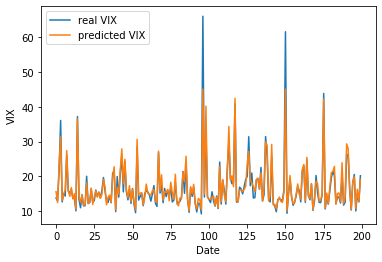

[15.646873 11.845377 15.691071 12.84669  14.570139 13.942439 12.88476
 14.189407 13.710281 21.165876 42.751663 25.376318 15.325762 24.746323
 13.793274 23.262709 20.714247 19.44815  20.07223  10.528345 21.073658
 19.60088  13.953802 18.66417  15.910706 16.147314 11.276711 10.880678
 13.389044 13.64745 ]


In [60]:
divi_for_training = pred_all - y_all
output = divi_for_training.flatten()


fir = y_all + shifted_value
sec = pred_all + shifted_value

print(fir[1700:1730])

fig = plt.figure()
# plt.plot(y_all + shifted_value, label='real VIX')
# plt.plot(pred_all + shifted_value, label='predicted VIX')
plt.plot(fir[1500:1700], label='real VIX')
plt.plot(sec[1500:1700], label='predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()
fig.savefig('output_prediction.jpg', bbox_inches='tight')

print(sec[1700:1730])

In [42]:
output = pd.DataFrame(output)
output.to_csv("demo.csv")

In [47]:

output = pd.DataFrame(predicted_values-y_test)
output.to_csv("demo.csv")

